### __Problema de prueba 1. conduccion difución Two dimensional rotating Gaussian pulse 


In [1]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
from matplotlib.legend_handler import HandlerLine2D
from label_lines import *
import math
import scipy
import time
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
import pandas as pd
from mshr import *
import sys
import os
from pathlib import Path
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
parameters['linear_algebra_backend'] = 'Eigen'
start_code = time.time()
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    exp_A =scipy.linalg.expm(tau*A)
    return (exp_A-d)*spsl.spsolve(tau*A,d) , exp_A
# algoritmo de arnoldi 
def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-4
    n_int=4
    n=n_int
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>n_int or (n==n_int and j==n_int):
            fi_m,exp_H =fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
    print(f"H dim= {V.shape[1]} error = {error}")
    return V[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H 
class left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0],0) and on_boundary
class right(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0],1)
def exp_form(mesh):
    V=FunctionSpace(mesh,"CG",1)

    u_n=project(u_0,V)

    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)

    #bc1 =DirichletBC(V,Constant(20),boundaries,1)
    # bc2 =DirichletBC(V,Constant(25),boundaries,2)
    bcs =DirichletBC(V, bc_2, contorno,2)    # bcs=[bc2]
    # ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
    K_fem = dot(grad(u), grad(v))*dx # Formulación débil
    C_fem=u*v*dx
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    Q_fem =v*f*dx +v*q*ds(1)
    #ensamble matriz capacitiva 
    C=assemble(C_fem)
    
    #ensamble matriz de rigidez
    K=assemble(K_fem)
    #  #penalización

    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(K) for bc in bcs]
            [bc.apply(C) for bc in bcs]#penalización
        else:
            bcs.apply(K)
            bcs.apply(C)
    #metodo sparse
    K_=scipy.sparse.csr_matrix(-K.array()) 
    N_degree=C.array().shape[0]
    C_=scipy.sparse.csc_matrix(C.array())
    I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
    C_1=scipy.sparse.linalg.spsolve(C_,I_n)

    #metodo coarse np
    A=C_1.dot(K_)
    A=A.toarray()
    # print("K matrix" , K_.toarray())
    # print("C matrix" , C_.toarray())  
    return(V,u,v,A,C_1,Q_fem,u_n,bcs)

def Q_t(Q_fem,C_1,u_t,v_t,f,bcs=0):

    Q_v=assemble(Q_fem)
    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(Q_v) for bc in bcs] #penalización
        else:
            bcs.apply(Q_v)
    Q_ = Q_v.get_local()
    Q_a =C_1.dot(Q_)
    return Q_a
def exp_solver(A,u_i,n,table,u=0):
    arnoldi_ti=time.time()
    Beta=np.linalg.norm(u_i)
    V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i,real_dt)
    arnoldi_t=time.time()-arnoldi_ti
    solver_ti=time.time()
    if n==0:
        u = real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_n.vector().get_local()
    else:
        u += real_dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
    solver_t=time.time() -solver_ti
    table.append([arnoldi_t,solver_t,V_m.shape[1]])
    return(u)

def BDF_form(mesh,pconst):
    V=FunctionSpace(mesh,"P",1)

    # Definición del problema variacional
    u = TrialFunction(V)  # Función de prueba
    v = TestFunction(V)   # Función de test
    n=FacetNormal(mesh)

    
    # Definición del valor inicial
    u_n = Function(V)
    u_n = interpolate(u_0, V)  # Interpola u_D en el espacio de funciones V
    u_nn = Function(V)
    u_nn = project(u_0, V) 
    u_nnn = Function(V)
    u_nnn = project(u_0, V) 


    du=pconst[0]*u
    du_n=pconst[1]*u_n
    du_nn=pconst[2]*u_nn
    du_nnn=pconst[3]*u_nnn
    du_t= du+du_n +du_nn +du_nnn


    bcs =DirichletBC(V, bc_2, contorno,2)
    
    ds = Measure('ds', domain=mesh, subdomain_data=contorno)
    F = du_t*v*dx + real_dt*dot(grad(u), grad(v))*dx  - real_dt*v*f*dx - real_dt*v*q*ds(1)

    L, R = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
    A1 = assemble(L)
    
    if bcs != 0:
        if isinstance(bcs, list):
            [bc.apply(A1) for bc in bcs]#penalización
        else:
            bcs.apply(A1)
    return(V,A1,R,bcs,u_n,u_nn,u_nnn)
def b_n(n):
    return 8/((1-2*n)**2*np.pi**2)
def Analytic(x,t):
    if t <= 0.1:
        s_m = 10000
    else: 
        s_m = 100
    u=[]
    j=0
    for x_n in x:
        u_j=0
        for n in range(1,s_m):
            u_j += b_n(n)*math.exp(-1*((n-0.5)*np.pi)**2*t)*np.cos((n-0.5)*np.pi*x_n)
        u_j += x_n+24
        u.append(u_j)
    return u
    


step:1 of 200 time = 0
H dim= 30 error = 4.925624668302216e-05


/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
/home/sebastian/anaconda3/envs/fenics_base/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


step:2 of 200 time = 0.001
H dim= 21 error = 7.272396742599722e-05
step:3 of 200 time = 0.002
H dim= 20 error = 4.1627371458653705e-05
step:4 of 200 time = 0.003
H dim= 18 error = 8.902231920810499e-05
step:5 of 200 time = 0.004
H dim= 18 error = 3.9885935937428696e-05
step:6 of 200 time = 0.005
H dim= 17 error = 3.9454434433824044e-05
step:7 of 200 time = 0.006
H dim= 17 error = 5.545737762406677e-05
step:8 of 200 time = 0.007
H dim= 16 error = 6.975992659499178e-05
step:9 of 200 time = 0.008
H dim= 16 error = 4.542272186816197e-05
step:10 of 200 time = 0.009000000000000001
H dim= 15 error = 5.629106560092593e-05
step:11 of 200 time = 0.010000000000000002
H dim= 16 error = 3.623038018981225e-05
step:12 of 200 time = 0.011000000000000003
H dim= 15 error = 9.270778550545982e-05
step:13 of 200 time = 0.012000000000000004
H dim= 16 error = 7.842944373660423e-05
step:14 of 200 time = 0.013000000000000005
H dim= 16 error = 5.361537813809668e-05
step:15 of 200 time = 0.014000000000000005
H d

H dim= 12 error = 7.419458784819307e-05
step:104 of 200 time = 0.10300000000000008
H dim= 11 error = 9.440304487220236e-05
step:105 of 200 time = 0.10400000000000008
H dim= 13 error = 2.910776116421154e-05
step:106 of 200 time = 0.10500000000000008
H dim= 11 error = 4.4783664814460876e-05
step:107 of 200 time = 0.10600000000000008
H dim= 11 error = 6.830475524319195e-05
step:108 of 200 time = 0.10700000000000008
H dim= 12 error = 6.225140746949444e-05
step:109 of 200 time = 0.10800000000000008
H dim= 12 error = 4.422402135903907e-05
step:110 of 200 time = 0.10900000000000008
H dim= 12 error = 4.862463206166313e-05
step:111 of 200 time = 0.11000000000000008
H dim= 11 error = 8.885932565351358e-05
step:112 of 200 time = 0.11100000000000008
H dim= 12 error = 8.766698069823032e-05
step:113 of 200 time = 0.11200000000000009
H dim= 12 error = 7.679431465101179e-05
step:114 of 200 time = 0.11300000000000009
H dim= 12 error = 9.256713005565549e-05
step:115 of 200 time = 0.11400000000000009
H d

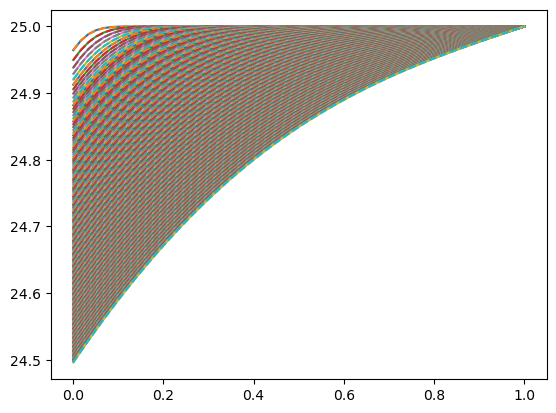

In [7]:

start_code = time.time()
dt = 0.001
nx = ny = 60  #nx ny
solver  = 'exp'  # time integration method
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})


# Parámetros de simulación
T = 0.2            # Tiempo final
num_steps = int(T/dt)# Número de pasos de tiempo
real_dt= dt

#f=Expression('x[0]*(6*t - pow(x[0], 2) - 4*pow(x[0], 2)*t*t)*exp(-t*pow(x[0], 2))',t=0,degree=2)
f=Expression('0',t=0,degree=2) 
#f=Expression('4',t=0,degree=2) 
q=Expression('-1',t=0,degree=2) #neumman BC


#u_a = Expression('(sin(2*x[0]*pi))*exp(-t)',t=0,degree=2)
u_0 = Expression('25',degree=2)
#bc_1= Constant(0.0) #left
bc_2= Constant(25)
BDF_coef = {"BDF1":[1,-1,0,0],"BDF2":[3./2,-2,1./2,0.0],"BDF3":[11/6,-3,3/2,-1/3],"BDF_OP":[0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3]}

# Creación de la malla y definición del espacio de funciones

start = 0
x_end = 1
mesh = IntervalMesh(nx, start, x_end)
contorno = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
left().mark(contorno, 1)
right().mark(contorno, 2)


# vtkfile_u = XDMFFile(f"results_dt_{dt}/u_analytical.xdmf")
# vtkfile_u.parameters["flush_output"] = True
# vtkfile_u.parameters["rewrite_function_mesh"] = False
# vtkfile_uh = XDMFFile(f"results_dt_{dt}/u_{solver}.xdmf")
# vtkfile_uh.parameters["flush_output"] = True
# vtkfile_uh.parameters["rewrite_function_mesh"] = False

try:
    os.mkdir(f"results_dt_{real_dt}") 
except FileExistsError:
    pass
t= 0
if solver == "exp":
    assemble_ti=time.time()
    V,u_t,v_t,A,C_1,Q_a,u_n,bcs = exp_form(mesh)
    assemble_t =time.time()- assemble_ti
elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
    V,L,R,bcs,u_n,u_nn,u_nnn = BDF_form(mesh,BDF_coef[solver])
else: 
    print("esquema de integración temporal erroneo")
    exit()
u_=Function(V)

L2=[]
table =[]
for n in range(num_steps):
    f.t=t
    q.t=t
    bc_2.t=t
    print(f'step:{n+1} of {num_steps} time = {t}')
    if solver == "exp":

        Q=Q_t(Q_a,C_1,u_t,v_t,f,bcs)
        if n ==0:
            u_i=np.dot(A,u_n.vector().get_local())+Q
            u =exp_solver(A,u_i,n,table)
        else:
            u_i=np.dot(A,np.array(u)[0])+Q
            u =exp_solver(A,u_i,n,table,u)

        u_.vector()[:]=np.array(u)[0]
    elif (solver == "BDF1")or(solver == "BDF2") or (solver == "BDF3") or (solver == "BDF_OP"):
        Q = assemble(R)
        if bcs != 0:
            if isinstance(bcs, list):
                [bc.apply(Q) for bc in bcs]#penalización
            else:
                bcs.apply(Q)
            solve(L, u_.vector(),Q)
        u_nnn.assign(u_nn)
        u_nn.assign(u_n)
        u_n.assign(u_)
    t += real_dt
#     u_.rename("u_"+solver, "u_"+solver);vtkfile_uh.write(u_, t)
    #u_an=project(u_a,V)
#     u_an.rename("u", "u");vtkfile_u.write(u_an, t) 
    x_cor=np.linspace(0,1,60)
    u_p=[]
    for i in x_cor:
        u_p.append(u_(i))
    u_a =Analytic(x_cor,t )

#     if near(t,0.1,real_dt/2) or near(t,0.5,real_dt/2) or near(t,1,real_dt/2) :
    plt.plot(x_cor,u_p)
    plt.plot(x_cor,u_a,'--')
    L2_norm=np.sum((np.array(u_a)-np.array(u_p))**2)**0.5 #assemble((u_ - u_an)**2 * dx)**0.5
    L2.append([L2_norm,t])
# plt.grid(True)
# plt.xlim = [0,1]
# plt.ylim = [24,25]
# plt.show()    
        
#     end_code = time.time()
#     exec_t=end_code-start_code
#     print("execution time: ", exec_t )
#     error=pd.DataFrame(L2,columns=[solver,'tiempo'])
#     error.to_csv(f'results_dt_{real_dt}/error_scheme_{solver}.csv')
#     time_path=Path(f"time_error_{solver}.csv")
#     solution=[np.linalg.norm(error[solver].to_numpy()),real_dt, exec_t ]
#     solution =pd.DataFrame([solution],columns=['L2_norm_sum','dt','cpu_time'])
#     if not time_path.is_file():
#         solution.to_csv(f"time_error_{solver}.csv",index=False)
#     else : 
#         histor=pd.read_csv(f'time_error_{solver}.csv')
#         update=pd.concat([histor,solution],sort=False)
#         update.to_csv(f"time_error_{solver}.csv",index=False)
    
    
#     if solver == "exp":
#         exp_path=Path('exp_times.csv')
#         time_sta =pd.DataFrame(table,columns=['krylov_t','solver_t','m'])
#         exp_dat=pd.DataFrame([[time_sta['krylov_t'].mean(),time_sta['solver_t'].mean(),exec_t,time_sta['m'].mean()]],columns=['mean_kylov_projection_time','mean_solver_time','cpu_time','mean_krylov_dimension_$m$'])
#         print(time_sta['krylov_t'].mean(),time_sta['solver_t'].mean(),exec_t,time_sta['m'].mean())
#         if  not exp_path.is_file():
#             exp_dat.to_csv(f"exp_times.csv",index=False)
#         else : 
#             exp_h=pd.read_csv(f'exp_times.csv')
#             exp_dat=pd.concat([exp_h,exp_dat],sort=False)
#             exp_dat.to_csv(f"exp_times.csv",index=False)


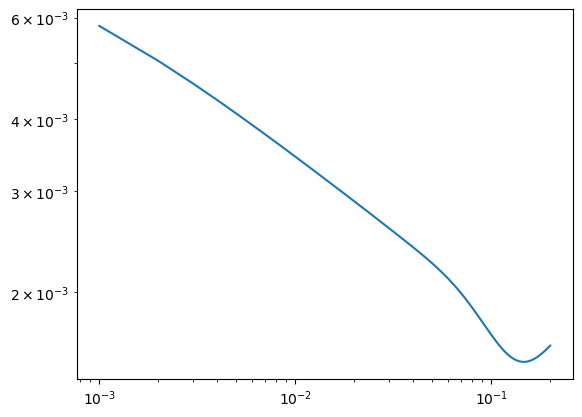

In [6]:
Lse=np.array(L2)
plt.loglog(Lse[:,1],Lse[:,0])

In [26]:
1.50 -0.10 -0.10 -0.10 -0.10 -0.10 -0.10 -0.10 -0.10 -0.10  0.50

Solving linear variational problem.
t = 0.02: error = 0.0116
Solving linear variational problem.
t = 0.04: error = 0.0116
Solving linear variational problem.
t = 0.06: error = 0.0116
Solving linear variational problem.
t = 0.08: error = 0.0116
Solving linear variational problem.
t = 0.10: error = 0.0116
Solving linear variational problem.
t = 0.12: error = 0.0116
Solving linear variational problem.
t = 0.14: error = 0.0116
Solving linear variational problem.
t = 0.16: error = 0.0116
Solving linear variational problem.
t = 0.18: error = 0.0116
Solving linear variational problem.
t = 0.20: error = 0.0116
Solving linear variational problem.
t = 0.22: error = 0.0116
Solving linear variational problem.
t = 0.24: error = 0.0116
Solving linear variational problem.
t = 0.26: error = 0.0116
Solving linear variational problem.
t = 0.28: error = 0.0116
Solving linear variational problem.
t = 0.30: error = 0.0116
Solving linear variational problem.
t = 0.32: error = 0.0116
Solving linear variation

NameError: name 'interactive' is not defined

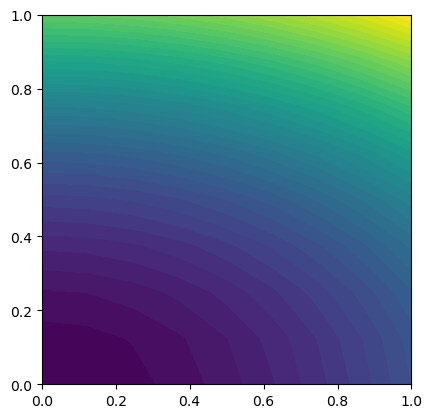

In [14]:
from fenics import *
import numpy as np

T = 2.0            # final time
num_steps = 100     # number of time steps
dt = T / num_steps # time step size
alpha = 3          # parameter alpha
beta = 1.2         # parameter beta

# Create mesh and define function space
nx = ny = 8
mesh = UnitSquareMesh(nx, ny)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                 degree=2, alpha=alpha, beta=beta, t=0)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define initial value
u_n = interpolate(u_D, V)
#u_n = project(u_D, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(beta - 2 - 2*alpha)

F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    u_D.t = t

    # Compute solution
    solve(a == L, u, bc)

    # Plot solution
    plot(u)

    # Compute error at vertices
    u_e = project(u_D, V)
    error = np.abs(u_e.vector().get_local() - u.vector()).max()
    print('t = %.2f: error = %.3g' % (t, error))

    # Update previous solution
    u_n.assign(u)

# Hold plot
interactive()

array([ 82.44,  74.40,  67.19,  60.79,  55.22,  50.49,  46.59,  43.55,
        41.38,  40.07,  39.63])

In [22]:
time inv =0.003248453140258789
[ 0.00  0.00 -0.00  0.00 -0.01  0.05 -0.18  0.67 -2.49  9.28 -34.64]
H dim= 10 error = 1.1144652905028158e-13
step:0 of 2 time= 0.5
[ 0.00 -0.09 -0.18 -0.26 -0.34 -0.41 -0.47 -0.52 -0.55 -0.58 -0.58]
H dim= 2 error = 7.169565261402884e-08

C_1
[[ 1.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
 [-0.27  16.08 -4.31  1.15 -0.31  0.08 -0.02  0.01 -0.00  0.00 -0.00]
 [ 0.07 -4.31  17.23 -4.62  1.24 -0.33  0.09 -0.02  0.01 -0.00  0.00]
 [-0.02  1.15 -4.62  17.31 -4.64  1.24 -0.33  0.09 -0.02  0.01 -0.00]
 [ 0.01 -0.31  1.24 -4.64  17.32 -4.64  1.24 -0.33  0.09 -0.03  0.01]
 [-0.00  0.08 -0.33  1.24 -4.64  17.32 -4.64  1.24 -0.33  0.10 -0.05]
 [ 0.00 -0.02  0.09 -0.33  1.24 -4.64  17.32 -4.64  1.25 -0.36  0.18]
 [-0.00  0.01 -0.02  0.09 -0.33  1.24 -4.64  17.33 -4.66  1.33 -0.67]
 [ 0.00 -0.00  0.01 -0.02  0.09 -0.33  1.25 -4.66  17.41 -4.97  2.49]
 [-0.00  0.00 -0.00  0.01 -0.03  0.10 -0.36  1.33 -4.97  18.56 -9.28]
 [ 0.00 -0.00  0.00 -0.00  0.01 -0.05  0.18 -0.67  2.49 -9.28  34.64]]

A
[[-1.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00, 0.00,  0.00],
[ 161.04, -364.62,  258.47, -69.26,  18.56, -4.97,  1.33, -0.36, 0.10, -0.03,  0.01],
[-43.15,  258.47, -433.87,  277.03, -74.23,  19.89, -5.33,  1.43,-0.38,  0.11, -0.03],
[ 11.56, -69.26,  277.03, -438.85,  278.36, -74.59,  19.99, -5.36,1.44, -0.41,  0.10],
[-3.10,  18.56, -74.23,  278.36, -439.20,  278.45, -74.61,  20.00,-5.38,  1.54, -0.38],
[ 0.83, -4.97,  19.89, -74.59,  278.45, -439.23,  278.47, -74.64,20.10, -5.74,  1.44],
[-0.22,  1.33, -5.33,  19.99, -74.61,  278.47, -439.26,  278.56, -75.00,  21.43, -5.36],
[ 0.06, -0.36,  1.43, -5.36,  20.00, -74.64,  278.56, -439.62, 279.90, -79.97,  19.99],
[-0.02,  0.10, -0.38,  1.44, -5.38,  20.10, -75.00,  279.90, -444.59,  298.45, -74.61],
[ 0.00, -0.03,  0.11, -0.41,  1.54, -5.74,  21.43, -79.97, 298.45, -513.84,  278.46],
[-0.00,  0.01, -0.05,  0.21, -0.77,  2.87, -10.71,  39.99, -149.23,  556.92, -439.23]]






u_n
[ 25.00,  25.00,  25.00,  25.00,  25.00,  25.00,  25.00,  25.00,
        25.00,  25.00,  25.00]



0.5

time: 0.9


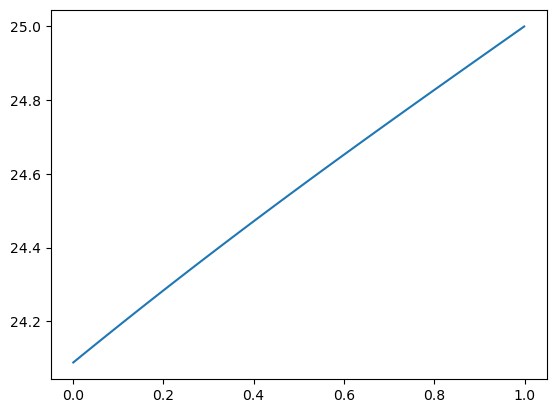

In [39]:
plt.plot(x_cor,Analytic(x_cor,0.9 ))

<Axes: title={'center': 'Error convergence for dt = 1'}, xlabel='time', ylabel='L2 norm'>

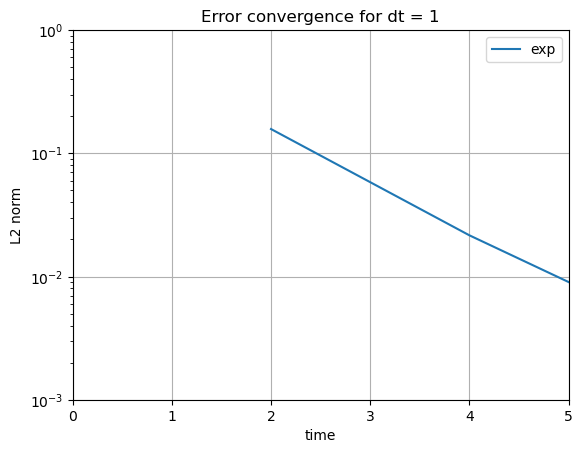

In [75]:
error.plot(x='tiempo',xlim=[0,5],ylim=[1E-3,1],title=f"Error convergence for dt = {dt}",logy=True,grid=True,xlabel='time',ylabel='L2 norm')

[]

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


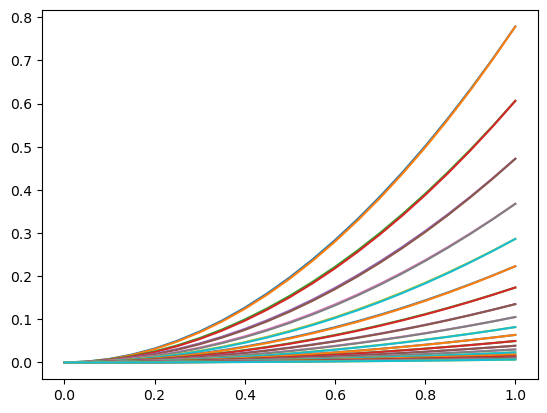

In [5]:
from fenics import *
import time
import matplotlib.pyplot as plt
T = 5          # final time
num_steps = 20# number of time steps
dt = T / num_steps # time step size

# Create mesh and define function space
nx = ny = 20
start = 0
x_end = 1
mesh = IntervalMesh(nx, start, x_end)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
def inner_point(x, on_boundary):
    return near(x[0],0) 

def boundary(x, on_boundary):
    return on_boundary

# Define initial value
u_0 = Expression('pow(x[0],2)',degree=2)
u_n = interpolate(u_0, V)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f=Expression('-(pow(x[0],2)+2)*exp(-t)',t=0,degree=2)
u_a = Expression('exp(-t)*(pow(x[0],2))',t=0,degree=3)
bc1 = DirichletBC(V, u_a, boundary)
bc2 = DirichletBC(V, 0.0, inner_point)
bcs=[bc2]
n=FacetNormal(mesh)
F = u*v*dx + dt*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx
a, L = lhs(F), rhs(F)

# Create VTK file for saving solution
vtkfile = File('heat_gaussian/solution.pvd')
vtkfile_a = File('heat_gaussian/analytical.pvd')
# Time-stepping
u = Function(V)
t = 0
for n in range(num_steps):

    # Update current time
    t += dt
    f.t=t
    u_a.t=t
    u_analytical=project(u_a,V)
    # Compute solution
    solve(a == L, u,bc1)
    
    # Save to file and plot solution
    

    # Update previous solution
    u_n.assign(u)
    plot(u)
    plot(u_analytical)

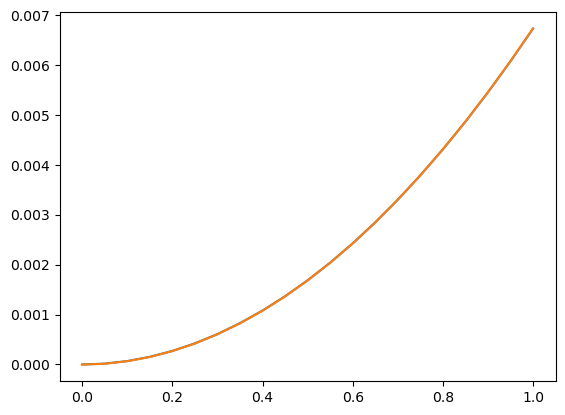

time inv =0.003248453140258789
[ 0.00  0.00 -0.00  0.00 -0.01  0.05 -0.18  0.67 -2.49  9.28 -34.64]
H dim= 10 error = 1.1144652905028158e-13
step:0 of 2 time= 0.5
[ 0.00 -0.09 -0.18 -0.26 -0.34 -0.41 -0.47 -0.52 -0.55 -0.58 -0.58]
H dim= 2 error = 7.169565261402884e-08
step:1 of 2 time= 1.0


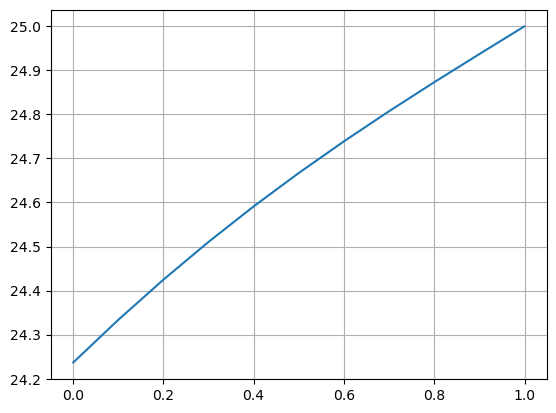

In [36]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time
import scipy
import scipy.sparse as sps
import scipy.sparse.linalg as spsl
from mshr import *
start = time.time()
np.set_printoptions(formatter={'float': '{: 0.2F}'.format})
parameters['linear_algebra_backend'] = 'Eigen'

# Parámetros de simulación
T = 1           # Tiempo final
num_steps = 2# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
a=-1
# mesh
elements = 10
start = 0
x_end = 1
mesh = IntervalMesh(elements, start, x_end)  # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D

# boundary markers
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], start) and on_boundary


class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], x_end) and on_boundary


boundaries= MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

LeftBoundary().mark(boundaries, 1)  # mark left boundary with a 0
RightBoundary().mark(boundaries, 2)  # mark right boundary with a 1
V=FunctionSpace(mesh,"CG",1)
# Definición de la condición inicial
u_0 =Expression(('25'),degree=2)

u_n=project(u_0,V)

# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)

#bc1 =DirichletBC(V,Constant(20),boundaries,1)
bc2 =DirichletBC(V,Constant(25),boundaries,2)
bcs=[bc2]
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
K_fem = k*dot(grad(u), grad(v))*dx # Formulación débil
Q_fem =v*a*ds(1)

C_fem=u*v*dx
#ensamble vector de cargas

Q_v=assemble(Q_fem)
[bc.apply(Q_v) for bc in bcs] #penalización
#ensamble matriz capacitiva 
C=assemble(C_fem)
[bc.apply(C) for bc in bcs]#penalización
#ensamble matriz de rigidez

K=assemble(K_fem)
[bc.apply(K) for bc in bcs] #penalización


#metodo sparse
K_=scipy.sparse.csr_matrix(-K.array()) 
# plt.spy(s)
# plt.colorbar()
# plt.show()
N_degree=C.array().shape[0]
C_=scipy.sparse.csc_matrix(C.array())
I_n=scipy.sparse.csc_matrix(scipy.sparse.identity(N_degree))
Q_v=Q_v.get_local()

start=time.time()
C_1=scipy.sparse.linalg.spsolve(C_,I_n)

end = time.time()
#metodo coarse np
A=C_1.dot(K_)

A=A.toarray()
A_i=scipy.sparse.linalg.spsolve(A,I_n)
A_i=A_i.toarray()
Q=C_1.dot(Q_v)


# algoritmo de arnoldi 
def fi (A,m,tau=1):
    d=scipy.sparse.identity(m)
    exp_A =scipy.linalg.expm(tau*A)
    return (exp_A-d)*spsl.spsolve(tau*A,d) , exp_A
# algoritmo de arnoldi 
def arnoldi_iteration(A, b,tau):
    m = A.shape[0]
    beta= np.linalg.norm(b)
    tol=1E-4
    n=2
    error=1
    #print("beta on er",beta)
    eta=1/sqrt(2)
    H = np.zeros((n + 1, n))
    V = np.zeros((m, n + 1))
    V[:, 0] = b / beta
    j=0
    while error >= tol:
        if n>2 :
            H=np.pad(H, [(0, 1), (0, 1)], mode='constant', constant_values=0)
            V=np.pad(V, [(0, 0), (0, 1)], mode='constant', constant_values=0)
        e_m=np.zeros(n)
        e_m[n-1]=1
        e_1=np.zeros(n)
        e_1[0]=1
        v = A.dot(V[:, j])
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i].conj(), v)  # <-- V needs conjugation!
            v = v - H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(v)
        V[:, j + 1] = v / H[j + 1, j]
        j += 1
        if n>2 or (n==2 and j==2):
            fi_m,exp_H =fi(H[0:n, 0:n],n,tau)
            error = beta*abs(H[n,n-1]*tau*e_m.dot(np.array(fi_m.dot(e_1))[0]))
            n += 1
    print(f"H dim= {n-1} error = {error}")
    return V[:,0:n-1], H[0:n-1, 0:n-1],fi_m,e_1,n,exp_H 



t= 0
u_=Function(V)


    

print(f"time inv ={end-start}")


u_i=np.dot(A,u_n.vector().get_local())+Q
m=2
v_hat=np.zeros(m)
v_hat[0]=1
#u_i=u_n.vector()

for n in range(num_steps):
   
    t += dt
    
    print(u_i)
    Beta=np.linalg.norm(u_i)
    V_m,H_m,fi_m,e_1,m,exp_H  = arnoldi_iteration(A,u_i,dt)
    #print(np.linalg.det(H_m))
#     u_.vector()[:]=u_i
    if n == 0:
        
        #u=dt*Beta*np.dot(V_m,Exp(H_m,dt)) + u_n.vector()
        u =  dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)+u_n.vector().get_local()
        #u =  dt*np.dot((np.dot((scipy.linalg.expm(dt*A)-I_n),A_i)),(np.dot(A,u_n.vector().get_local())+Q)) +u_n.vector().get_local()
    else:
        #u += dt*Beta*np.dot(V_m,Exp(H_m,dt))
        u += dt*Beta*np.dot(np.dot(V_m,fi_m),e_1.T)
        #u +=  dt*np.dot((np.dot((scipy.linalg.expm(dt*A)-I_n),A_i)),(np.dot(A,np.array(u)[0])+Q)) 
#         u_i=np.dot(scipy.linalg.expm(dt*A),u_i)
    u_.vector()[:]=np.array(u)[0]
    u_i=np.dot(A,np.array(u)[0])+Q
#     Beta=np.linalg.norm(u)
#     print(Beta)
    if n%100==0:
        x_cor=np.linspace(0.001,0.999,100)
        y=[]
        for i in x_cor:
            y.append(u_(i))
        plt.plot(x_cor,y)
    print(f'step:{n} of {num_steps} time= {t}')

plt.ylim=[24,25]
plt.grid(True)
plt.show()

In [35]:
u_n.vector().get_local()

array([ 25.00,  25.00,  25.00,  25.00,  25.00,  25.00,  25.00,  25.00,
        25.00,  25.00,  25.00])

time: 0.0001
time: 0.05341234567901235
time: 0.20450493827160496
time: 0.45337777777777777
time: 0.8000308641975309
time: 1.2444641975308643
time: 1.7866777777777778
time: 2.426671604938272
time: 3.164445679012346
time: 4.0


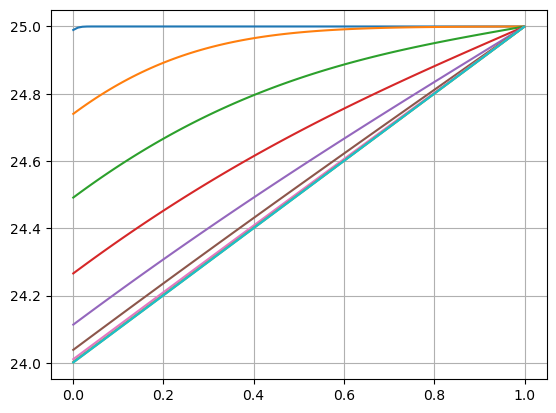

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt 
def b_n(n):
    return 8/((1-2*n)**2*np.pi**2)
def Analytic(x,t):
    print('time:', t)
    s_m=1000
    u=[]
    j=0
    for x_n in x:
        u_j=0
        for n in range(1,s_m):
            u_j += b_n(n)*math.exp(-1*((n-0.5)*np.pi)**2*t)*np.cos((n-0.5)*np.pi*x_n)
        u_j += x_n+24
        u.append(u_j)
    return u
x_a=np.linspace(0.001,0.999,100)
t_=np.linspace(0.01,2,10)**(2)
for t in t_:
    u_a =Analytic(x_a,t )
    plt.plot(x_a,u_a)
plt.grid(True)
plt.xlim = [0,1]
plt.ylim = [24,25]

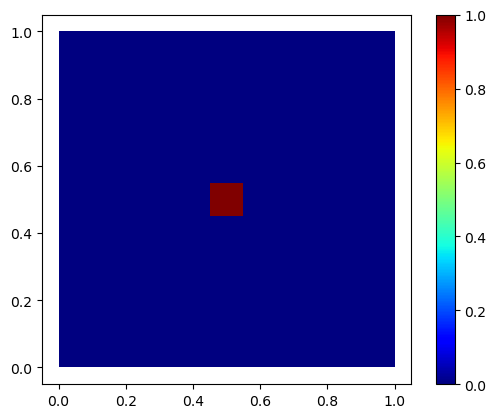

In [2]:
p=plot(subdomain)
p.set_cmap ('jet')
plt.colorbar(p)
plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.


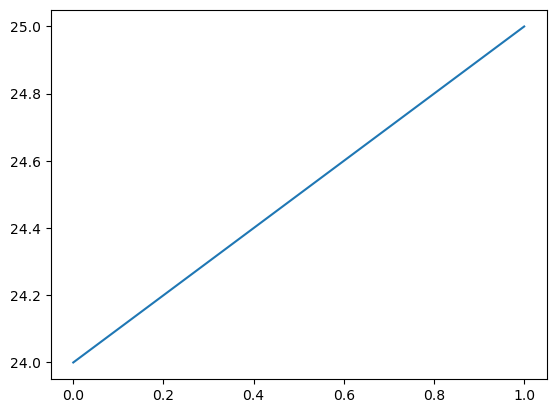

In [6]:
from __future__ import print_function
from fenics import *  # Importa FEniCS, una biblioteca popular para elementos finitos
import numpy as np  # NumPy para operaciones numéricas
import matplotlib.pyplot as plt  # Matplotlib para gráficos
import math
import time


from mshr import *
start = time.time()

parameters['linear_algebra_backend'] = 'Eigen'

    
np.set_printoptions(formatter={'float': '{: 0.2E}'.format})
# Parámetros de simulación
T = 1           # Tiempo final
num_steps = 600# Número de pasos de tiempo
dt = T / num_steps # Tamaño del paso de tiempo
k= 1
a=-1
# mesh
elements = 150
start = 0
x_end = 1
mesh = IntervalMesh(elements, start, x_end)  # use for 1D
#mesh = RectangleMesh(Point(start,start), Point(x_end,x_end/8), elements, 12)  # use for 2D

# boundary markers
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], start) and on_boundary


class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], x_end) and on_boundary


boundaries= MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

LeftBoundary().mark(boundaries, 1)  # mark left boundary with a 0
RightBoundary().mark(boundaries, 2)  # mark right boundary with a 1
V=FunctionSpace(mesh,"CG",1)
# Definición de la condición inicial
u_o =Expression(('25'),degree=2)



# Definición del problema variacional
u = TrialFunction(V)  # Función de prueba
v = TestFunction(V)   # Función de test
n=FacetNormal(mesh)





# Definición del valor inicial
u_n = interpolate(u_o, V)  # Interpola u_D en el espacio de funciones V
u_nn = interpolate(u_o, V) 
u_nnn = interpolate(u_o, V) 


# Formulación del problema variacional
#pconst=[3./2,-2,1./2,0.0] #bdf2
#pconst = [0.48*11/6+0.52*3/2,0.48*-3+0.52*-2,0.48*3/2+0.52*1/2,0.48*-1/3] #bdf2 op
pconst= [11/6,-3,3/2,-1/3] #bdf 3
#pconst=[1,-1,0,0] #bdf1

du=pconst[0]*u
du_n=pconst[1]*u_n
du_nn=pconst[2]*u_nn
du_nnn=pconst[3]*u_nnn
du_t= du+du_n +du_nn +du_nnn
t= 0

#bc1 =DirichletBC(V,Constant(20),boundaries,1)
bc2 =DirichletBC(V,Constant(25),boundaries,2)
bcs=[bc2]
ds = Measure('ds', domain=mesh, subdomain_data=boundaries)
F = k*dot(grad(u), grad(v))*dx - v*a*ds(1)# Formulación débil

a, L = lhs(F), rhs(F)  # Separa la parte izquierda y derecha de la ecuación
ig, ax = plt.subplots()
u_=Function(V)
solve(a==L,u_,bcs)
# for n in range(num_steps):
    

#     # Actualizar el tiempo actual
#     t += dt
#     print("time: ", t)
#     # Resolver la solución
# #     A=assemble(a)
# #     b=assemble(L)
# #     [bc.apply(A) for bc in bcs]
# #     [bc.apply(b) for bc in bcs]
# #     solve(A, u_.vector(),b)
#     solve(a==L,u_,bc2)
#     # Graficar la solución
#     #print(f'step:{n} of {num_steps}')
#     #print(np.array(u_.vector()).max())
#     # Calcular el error
# #     u_e = interpolate(u_D, V)  # Interpolar la solución exacta
# #     error = np.abs(np.array(u_e.vector()) - np.array(u.vector())).max()  # Error máximo
# #     print('t = %.2f: error = %.3g' % (t, error))

#     # Actualizar la solución anterior
#     u_nnn.assign(u_nn)
#     u_nn.assign(u_n)
#     u_n.assign(u_)

plot(u_)
plt.xlim = [0,1]
plt.ylim = [24,25]
plt.show()
        

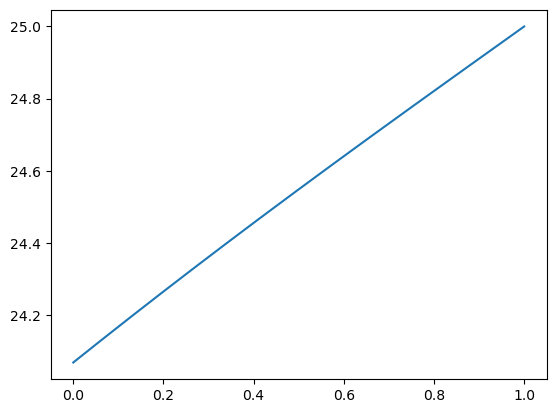

In [8]:
plot(u_)

AttributeError: 'list' object has no attribute 'set_cmap'

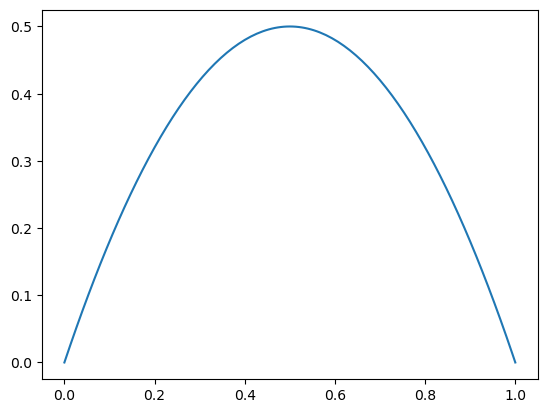

In [56]:
p=plot(u_n)
p.set_cmap ('jet')
plt.colorbar(p)

plt.show()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt



BDF1=[0.34503984451293945,2.5875508785247803,17.061789751052856,151.07883667945862,1684.5827815532684]

BDF2=[0.3183901309967041,3.061264753341675,18.664965867996216,132.02991819381714,1497.298812866211]
BDF3=[0.33373141288757324,2.5800626277923584,18.28300929069519,140.18803930282593,1582.6012518405914]
exp=[0.9195461273193359,5.702559947967529,27.684227466583252,154.98112630844116,1864.8093140125275]
dt_=[0.5,0.1,0.01,0.001,0.0001]
dict = {'dt': dt_, 'EXP': exp, 'BDF1': BDF1, 'BDF2': BDF2, 'BDF3': BDF3} 
time_exec=pd.DataFrame(dict)


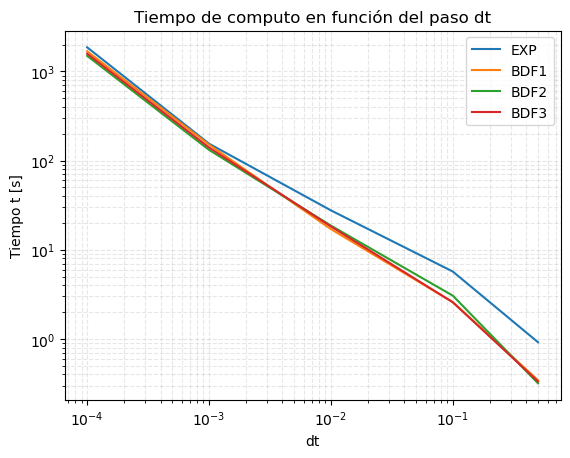

In [17]:
time_exec.plot(x='dt',title="Tiempo de computo en función del paso dt",loglog=True,grid=True,ylabel='Tiempo t [s]')
plt.grid(True,which="both",alpha=0.3, ls='--')
plt.savefig("tiempo de calculo.jpg")